<div style="background-color:#ede7f6; padding:12px; border-radius:8px;">
    <h2 style="color:#4527a0;">🍇 1. Importing Libraries</h2>
    <p style="font-size:15px; color:#311b92;">
        We will import all necessary libraries for:
        <ul>
            <li>📂 Data handling</li>
            <li>🖼️ Image processing</li>
            <li>🎨 Data augmentation</li>
            <li>📊 Visualization</li>
        </ul>
    </p>
</div>

In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import random_split
from torchvision.models import ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import joblib

<div style="background-color:#fffde7; padding:12px; border-radius:8px;">
    <h2 style="color:#f9a825;">🍋 2. Load the Dataset</h2>
    <p style="font-size:15px; color:#f57f17;">
        We will load the fruit images from the dataset directory.
        The dataset should have subfolders for each fruit class.
    </p>
</div>

In [2]:
# Path to dataset
dataset_path = "FRUIT-16K"  # Change this to your dataset path

# Check available classes
num_classes = os.listdir(dataset_path)
print(f"Found {len(num_classes)} classes: {num_classes}")

Found 16 classes: ['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']


<div style="background-color:#fce4ec; padding:12px; border-radius:8px;">
    <h2 style="color:#ad1457;">🍓 3. Data Augmentation</h2>
    <p style="font-size:15px; color:#880e4f;">
        We will improve model generalization by applying:
        <ul>
            <li>🔄 Random flips</li>
            <li>🔄 Random rotations</li>
            <li>🎨 Color jitter</li>
            <li>📏 Resizing</li>
        </ul>
    </p>
</div>

In [3]:
# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

# Load dataset with transformations
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)

<div style="background-color:#fff3e0; padding:12px; border-radius:8px;">
    <h2 style="color:#ef6c00;">🍊 4. Dataset Splitting</h2>
    <p style="font-size:15px; color:#e65100;">
        We will split the dataset into:
        <ul>
            <li>📚 <b>Training set</b> – 70%</li>
            <li>📏 <b>Validation set</b> – 15%</li>
            <li>🧪 <b>Test set</b> – 15%</li>
        </ul>
        A random seed will be set for reproducibility.
    </p>
</div>

In [4]:
# Set seed for reproducibility
torch.manual_seed(42)

# Calculate split sizes
train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

# Perform dataset split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Summary
print(f"Train: {len(train_dataset)} images in {len(train_loader)} batches")
print(f"Validation: {len(val_dataset)} images in {len(val_loader)} batches")
print(f"Test: {len(test_dataset)} images in {len(test_loader)} batches")

Train: 11200 images in 350 batches
Validation: 2400 images in 75 batches
Test: 2400 images in 75 batches


<div style="background-color:#ffebee; padding:12px; border-radius:8px;">
    <h2 style="color:#b71c1c;">🍅 5. Data Visualization</h2>
    <p style="font-size:15px; color:#880e4f;">
        We will display a sample of images from the training set
        to verify augmentations and data loading.
    </p>
</div>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5161401..1.82].


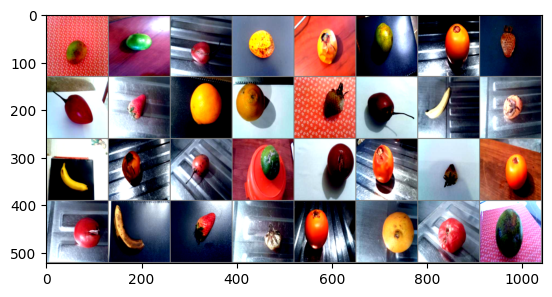

In [5]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

<div style="background-color:#FFE5A4; padding:12px; border-radius:8px;">
    <h2 style="color:#aa7b06;">🍍 6. Transfer Learning with ResNet50</h2>
    <p style="font-size:15px; color:#aa7b06;">
        We will apply <b>Transfer Learning</b> using a pre-trained <b>ResNet50</b> model
        to speed up training and reduce computational cost, while maintaining
        high accuracy for fruit classification.
        The feature extraction layers will be frozen, and only the final classification
        layer will be fine-tuned for our dataset.
        After training, the best model will be saved for future use.
    </p>
</div>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# 1. Load Pre-trained ResNet50
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze feature extractor layers
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the classifier layer (ResNet50's fc) for your number of classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, len(num_classes))

# Move to device
resnet50 = resnet50.to(device)

# 3. Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

# 4. Training Loop (Shortened epochs since using transfer learning)
def train_transfer_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=3):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            # Print every 10 batches
            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # Epoch training stats
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)

        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_accuracies.append(epoch_val_acc.item())

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    # 5. Test set evaluation
    test_loss, test_corrects = 0.0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)

    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects.double() / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_acc.item()

In [8]:
# Train the model
number_epoch = 3
resnet50, train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_acc = train_transfer_model(
    resnet50, train_loader, val_loader, test_loader, criterion, optimizer, epochs=number_epoch
)

Epoch 1, Batch 10/350, Loss: 2.2764
Epoch 1, Batch 20/350, Loss: 1.8707
Epoch 1, Batch 30/350, Loss: 1.4533
Epoch 1, Batch 40/350, Loss: 1.1844
Epoch 1, Batch 50/350, Loss: 1.0833
Epoch 1, Batch 60/350, Loss: 1.0097
Epoch 1, Batch 70/350, Loss: 0.6286
Epoch 1, Batch 80/350, Loss: 0.7710
Epoch 1, Batch 90/350, Loss: 0.6551
Epoch 1, Batch 100/350, Loss: 0.4799
Epoch 1, Batch 110/350, Loss: 0.5255
Epoch 1, Batch 120/350, Loss: 0.6093
Epoch 1, Batch 130/350, Loss: 0.4899
Epoch 1, Batch 140/350, Loss: 0.4240
Epoch 1, Batch 150/350, Loss: 0.3047
Epoch 1, Batch 160/350, Loss: 0.4758
Epoch 1, Batch 170/350, Loss: 0.3627
Epoch 1, Batch 180/350, Loss: 0.3982
Epoch 1, Batch 190/350, Loss: 0.4208
Epoch 1, Batch 200/350, Loss: 0.2662
Epoch 1, Batch 210/350, Loss: 0.3558
Epoch 1, Batch 220/350, Loss: 0.3808
Epoch 1, Batch 230/350, Loss: 0.2376
Epoch 1, Batch 240/350, Loss: 0.1759
Epoch 1, Batch 250/350, Loss: 0.2733
Epoch 1, Batch 260/350, Loss: 0.1949
Epoch 1, Batch 270/350, Loss: 0.1801
Epoch 1, B

In [9]:
# TEST MODEL
resnet50.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.17%


In [15]:
# Save the model
joblib.dump(resnet50, 'models/resnet50_transfer_learning_new.pkl')

['models/resnet50_transfer_learning_new.pkl']

In [17]:
# torch.save(resnet50, "models/resnet50_transfer_learning_new.pth")
torch.save(resnet50.state_dict(), "models/resnet50_transfer_learning_new.pth")

In [10]:
torch.save({
    'model_state_dict': resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': number_epoch
}, "models/checkpoint.pth")